# Step 3: Multi-Model Training and Comparison

## 1. Import Dependencies

In [197]:
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import confusion_matrix, f1_score

warnings.filterwarnings('ignore')

## 2. Load Processed Data

In [198]:
X_train = np.load('artifacts/X_train.npz')['arr_0']
Y_train = np.load('artifacts/Y_train.npz')['arr_0']
X_test = np.load('artifacts/X_test.npz')['arr_0']
Y_test = np.load('artifacts/Y_test.npz')['arr_0']

print("Data loaded successfully from artifacts.")

Data loaded successfully from artifacts.


## 3. Define Models and Cross-Validation Strategy

Here's what we are doing:
*   **Choose Models**: We pick three different models to see which one works best.
    *   `Logistic Regression`: A simple and reliable model.
    *   `Decision Tree`: Works like a flowchart to make decisions.
    *   `Random Forest`: A powerful model made of many decision trees.
*   **Set Up Testing Strategy**: We use `StratifiedKFold` to test our models fairly.
    *   It splits our data into 6 parts (`n_splits=6`).
    *   It ensures each part has a similar mix of 'churn' and 'not churn' customers.

### Mnemonic: **M-C-S** (Models, Cross-validation, Strategy)
*   **M** - **Models**: Pick your players (Logistic Regression, Decision Tree, Random Forest).
*   **C** - **Cross-Validation**: Set the rules of the game (Stratified K-Fold).
*   **S** - **Strategy**: Get ready to train and test fairly.

In [199]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

cv = StratifiedKFold(
    n_splits=6,
    random_state=42,
    shuffle=True
)

## 4. Train and Evaluate Models using Cross-Validation

How we train and pick the best version of each model:
*   **Loop Through Models**: We train each of our three models one by one.
*   **Cross-Validate**: For each model, we use our 6-part data split.
    *   Train on 5 parts, test on 1 part.
    *   Repeat this 6 times, so every part is used for testing once.
*   **Check F1-Score**: The `F1-score` tells us how good a model is. Higher is better.
*   **Select the Best Version**: Out of the 6 training rounds, we pick the model version (`estimator`) that got the highest F1-score.

### Mnemonic: **T-E-S-T** (Train, Evaluate, Select, Take)
*   **T** - **Train** the model on parts of the data.
*   **E** - **Evaluate** the F1-score on the test part.
*   **S** - **Select** the best score among the 6 rounds.
*   **T** - **Take** the model that achieved the best score.

In [200]:
trained_models = {}
cv_f1_scores = {}

for model_name, model in models.items():
    print(f"--- Training {model_name} ---")
    
    cv_results = cross_validate(
        model,
        X_train,
        Y_train,
        cv=cv,
        scoring='f1',
        return_estimator=True,
        return_train_score=False
    )
    
    test_scores = cv_results['test_score']
    best_index = np.argmax(test_scores)
    best_estimator = cv_results['estimator'][best_index]
    
    trained_models[model_name] = best_estimator
    cv_f1_scores[model_name] = np.mean(test_scores)
    
    print(f"Average F1 Score: {np.mean(test_scores):.4f}")
    print(f"Best estimator from fold {best_index + 1} selected.")

print("\nAll models trained successfully.")

--- Training Logistic Regression ---
Average F1 Score: 0.7193
Best estimator from fold 4 selected.
--- Training Decision Tree ---
Average F1 Score: 0.8430
Best estimator from fold 3 selected.
--- Training Random Forest ---
Average F1 Score: 0.9055
Best estimator from fold 6 selected.

All models trained successfully.


## 5. Compare Model Performance on Test Set

This is the final test for our models.
*   **Use Best Models**: We take the best version of each of our three models.
*   **Predict on New Data**: We use them to make predictions on the `test set`, which is data the models have never seen before.
*   **Check Final Scores**: We calculate the F1-score for each model on this new data to see how they perform in a real-world scenario.

In [201]:
Y_hat_tests = {}
test_f1_scores = {}

for model_name, model in trained_models.items():
    Y_hat_test = model.predict(X_test)
    Y_hat_tests[model_name] = Y_hat_test
    test_f1_scores[model_name] = f1_score(Y_test, Y_hat_test)

print("--- F1 Scores on Test Set ---")
scores_df = pd.DataFrame.from_dict(test_f1_scores, orient='index', columns=['F1 Score'])
display(scores_df.style.format('{:.4f}').background_gradient(cmap='summer'))

--- F1 Scores on Test Set ---


,F1 Score
Logistic Regression,0.4581
Decision Tree,0.4831
Random Forest,0.5707


## 6. Visualize Confusion Matrices

A **Confusion Matrix** helps us see where a model is right and where it's wrong.
*   It shows four types of predictions:
    *   **True Positives**: Correctly guessed "Churn".
    *   **True Negatives**: Correctly guessed "Not Churn".
    *   **False Positives**: Wrongly guessed "Churn" (it was actually "Not Churn").
    *   **False Negatives**: Wrongly guessed "Not Churn" (it was actually "Churn").
*   We will create one matrix for each model to easily compare their performance.

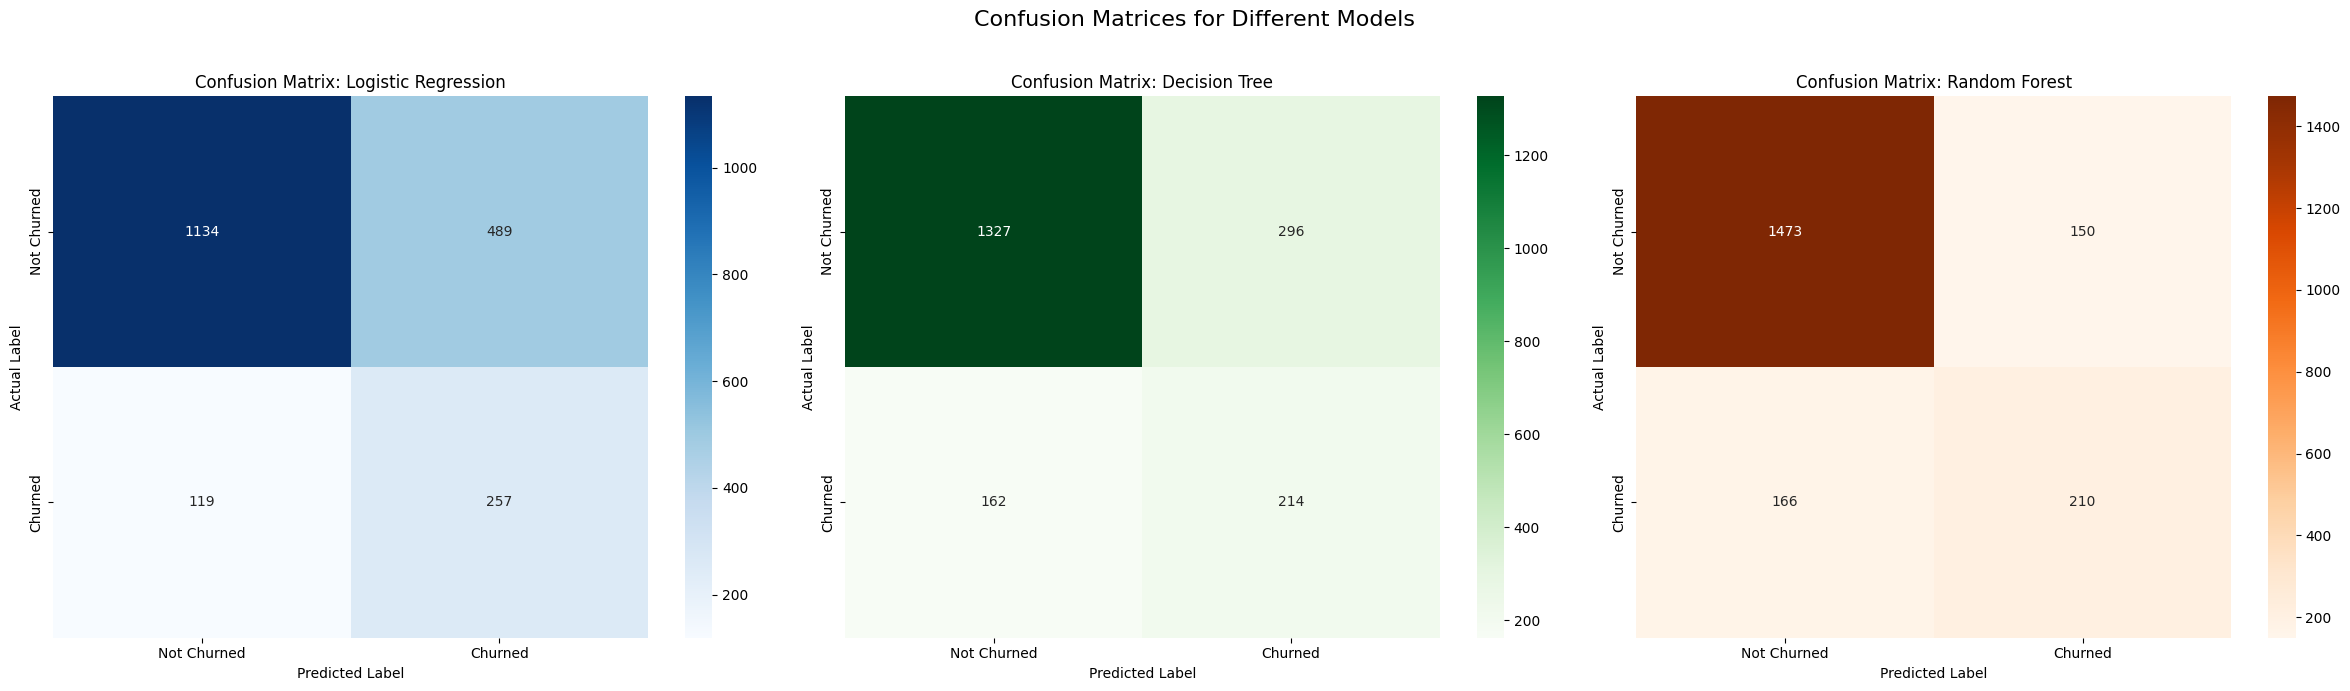

In [202]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Confusion Matrices for Different Models', fontsize=16)

colors = ['Blues', 'Greens', 'Oranges']

for ax, model_name, color in zip(axes, models.keys(), colors):
    cm = confusion_matrix(Y_test, Y_hat_tests[model_name])
    sns.heatmap(cm, annot=True, fmt='d', cmap=color, ax=ax,
                xticklabels=['Not Churned', 'Churned'],
                yticklabels=['Not Churned', 'Churned'])
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.grid(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 7. Save the Best Model

Time to pick the winner!
*   **Find the Champion**: We look at the final F1-scores on the test set.
*   **Select the Best**: The model with the highest F1-score is our winner.
*   **Save It**: We save this best model to a file (`best_model.pkl`) so we can use it later without retraining.

### Mnemonic: **F-S-S** (Find, Select, Save)
*   **F** - **Find** the highest F1-score.
*   **S** - **Select** the model that got that score.
*   **S** - **Save** the winning model to a file.

In [203]:
best_model_name = max(test_f1_scores, key=test_f1_scores.get)
best_model = trained_models[best_model_name]

joblib.dump(best_model, 'model/best_model.pkl')

print(f"🏆 Best performing model ('{best_model_name}') saved to 'model/best_model.pkl'.")

🏆 Best performing model ('Random Forest') saved to 'model/best_model.pkl'.
